## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from scipy import signal
from tqdm import tqdm
from scipy.ndimage import median_filter

## Loading image

In [2]:
main_img = cv.imread('slic.jpg')

In [3]:
main_img.shape

(3024, 4032, 3)

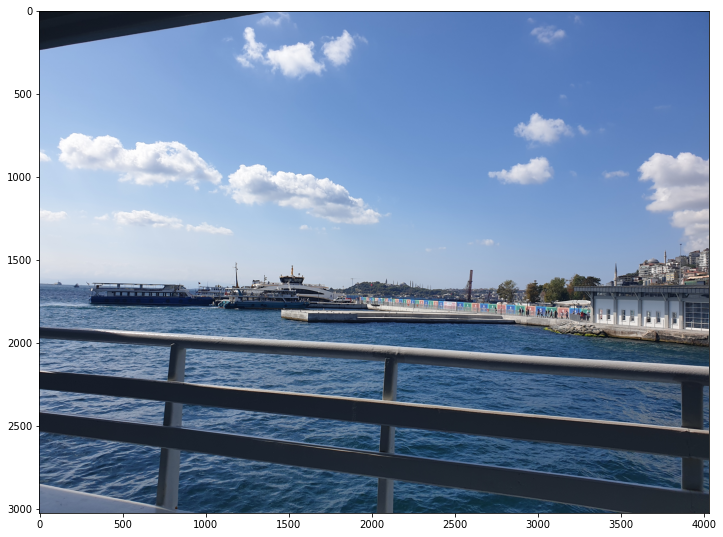

In [4]:
plt.figure(figsize=(12, 12))
plt.imshow(cv.cvtColor(main_img, cv.COLOR_BGR2RGB));

Features are in space $(L, A, B, X, Y)$

In [5]:
features = np.dstack((
    cv.cvtColor(main_img, cv.COLOR_BGR2LAB),
    np.transpose(np.indices(main_img.shape[:2]), (1, 2, 0))
)) # LABXY
features.shape

(3024, 4032, 5)

## SLIC

#### Gradient of the image

In [6]:
def normalize_between_zero_to_one(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

def get_img_grad_single_channel(img):
    x_filter = np.array([
        [1, 0, -1],
        [2, 0, -2],
        [1, 0, -1],
    ])
    y_filter = x_filter.T
    
    result_x = signal.convolve2d(img, x_filter, mode='valid')
    result_y = signal.convolve2d(img, y_filter, mode='valid')
    edge_img = np.sqrt(result_x**2 + result_y**2)
    edge_img = edge_img * img.max() / edge_img.max()
    
    return edge_img


def get_img_grad(img):
    res = np.stack([get_img_grad_single_channel(img[:, :, i]) for i in range(3)], axis=-1)
    return normalize_between_zero_to_one(res).astype(np.float32)

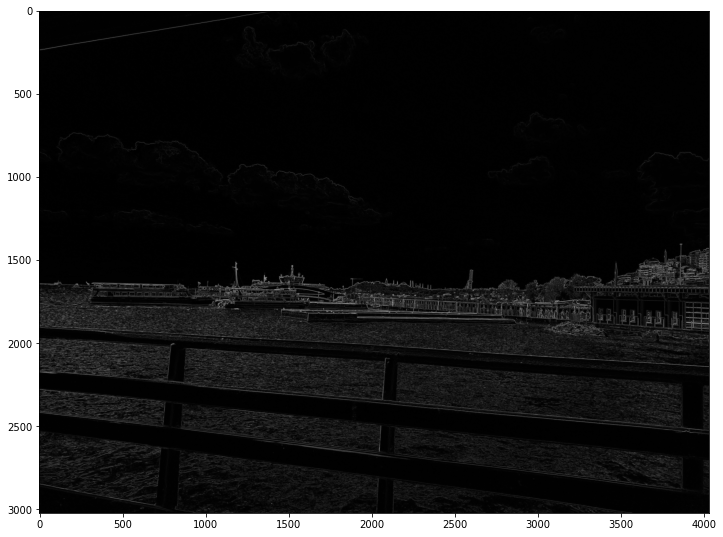

In [7]:
sobel_img = get_img_grad(main_img).mean(axis=2)
plt.figure(figsize=(12, 12))
plt.imshow(sobel_img, cmap='gray');

#### Distribute centers on image uniformly

In [8]:
def unif_dist_centers(img, cnt_i, cnt_j):
    half_radius_size_i, half_radius_size_j = (img.shape[0]//cnt_i)//2, (img.shape[1]//cnt_j)//2
    i_arr = np.linspace(0, img.shape[0]+1, cnt_i+1).astype(np.int16)[1:] - half_radius_size_i
    j_arr = np.linspace(0, img.shape[1]+1, cnt_j+1).astype(np.int16)[1:] - half_radius_size_j
    return np.stack(np.meshgrid(i_arr, j_arr), axis=2).reshape(-1, 2)

In [9]:
def draw_centers_on_img(img, centers, radius=15):
    tmp = img.copy()
    for c in centers:
        tmp[c[0]-radius:c[0]+radius, c[1]-radius:c[1]+radius] = [0, 0, 255]\

    plt.figure(figsize=(12, 12))
    plt.imshow(cv.cvtColor(tmp, cv.COLOR_BGR2RGB));

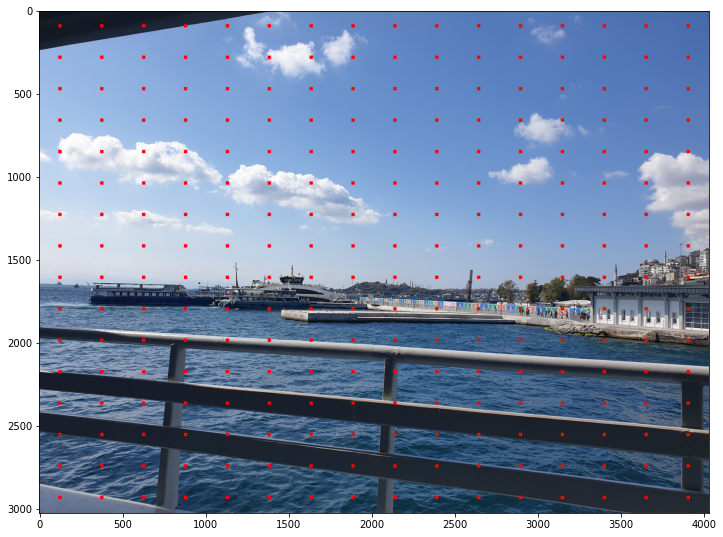

In [10]:
centers = unif_dist_centers(main_img, 16, 16)
S = centers[:2][:, 0].max() - centers[:2][:, 0].min()
draw_centers_on_img(main_img, centers, radius=10)

#### Move centers away from edges

In [11]:
def mode_image_away_from_edges(centers, sobel_img):
    search_boundry = 5
    for idx, c in enumerate(centers):
        neighbors = sobel_img[
            c[0]-search_boundry:c[0]+search_boundry+1,
            c[1]-search_boundry:c[1]+search_boundry+1
        ]
        min_grad_coord = np.unravel_index(neighbors.argmin(), neighbors.shape)
        centers[idx] = [c[0]-search_boundry+min_grad_coord[0], c[1]-search_boundry+min_grad_coord[1]]
    return centers

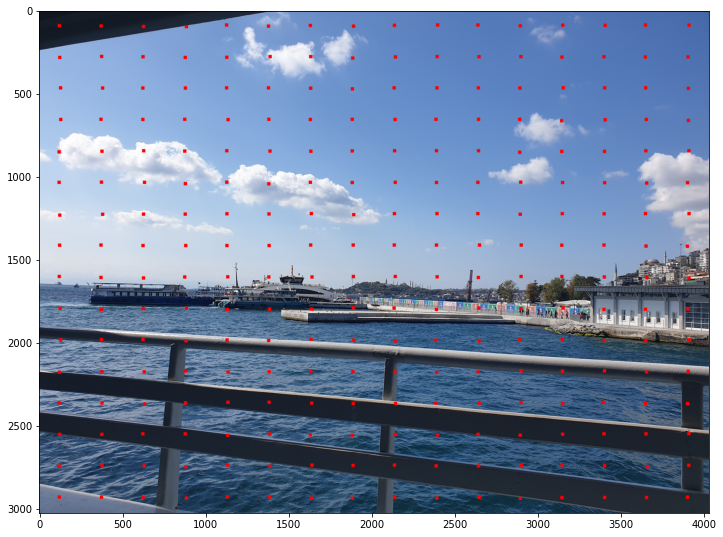

In [12]:
centers = mode_image_away_from_edges(centers, sobel_img)
draw_centers_on_img(main_img, centers, radius=10)

#### Segmentation

I set parameter `alpha` to be equal to $S/600$. This parameter should be related to $S$. I tunned it to $1/600$ after many experiments.

In [13]:
def segment(main_img, centers, features):
    labels = np.zeros(main_img.shape[:2])
    distances = np.full(main_img.shape[:2], np.inf)

    alpha = S/600
    for _ in tqdm(range(10)):
        labels = np.zeros(main_img.shape[:2])
        distances = np.full(main_img.shape[:2], np.inf)
        for c_idx, c in enumerate(centers):
            i_s, i_f = max(0, c[0]-S), min(main_img.shape[0], c[0]+S)
            j_s, j_f = max(0, c[1]-S), min(main_img.shape[1], c[1]+S)
            d_all = (features[i_s:i_f, j_s:j_f] - features[c[0], c[1]]) ** 2
            d_lab = np.sqrt(np.sum(d_all[:, :, :3], axis=2))
            d_xy = np.sqrt(np.sum(d_all[:, :, 3:], axis=2))
            D = d_lab + alpha * d_xy
            
            mask = D < distances[i_s:i_f, j_s:j_f]
            distances[i_s:i_f, j_s:j_f][mask] = D[mask]
            labels[i_s:i_f, j_s:j_f][mask] = c_idx
            
        prev_centers = centers.copy()
        for c_idx, c in enumerate(centers): 
            centers[c_idx] = np.mean(np.where(labels == c_idx), axis=1).astype(np.int32)

        if np.all(np.linalg.norm(prev_centers-centers, axis=1) < 1):
            print("Converged Earlier!")
            break
    
    return labels

In [14]:
labels = segment(main_img, centers, features)

100%|██████████| 10/10 [01:18<00:00,  7.83s/it]


This function outputs the boundries (based on labels)

In [15]:
def get_boundries(main_img, labels):
    is_on_boundry = np.zeros(main_img.shape[:2], dtype=bool)
    labels_pad = np.pad(labels, 1, mode='edge')
    for i_shift in range(-1, 2):
        for j_shift in range(-1, 2):
            i_s, j_s = 1 + i_shift, 1 + j_shift
            i_f, j_f = i_s + main_img.shape[0], j_s + main_img.shape[1]
            mask = ~(labels == labels_pad[i_s:i_f, j_s:j_f])
            is_on_boundry[mask] = True
    
    return is_on_boundry

This function draws boundries (based on a mask of boundries)

In [16]:
def draw_boundries(main_img, is_on_boundry):
    tmp = main_img.copy()
    tmp[is_on_boundry] = [0, 0, 255]
    plt.figure(figsize=(13, 13))
    plt.imshow(cv.cvtColor(tmp, cv.COLOR_BGR2RGB));

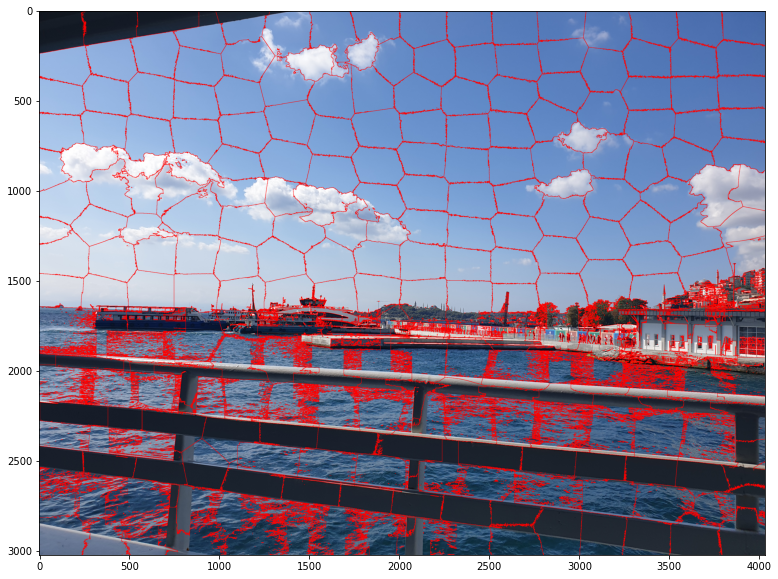

In [17]:
draw_boundries(main_img, get_boundries(main_img, labels))

Wee see that everything is segmented perfectly, but, we have a lot of noise in the see. This is because of the small disjoint components inside each other. We have to do the last step of the algorithm which is **Enforce Connectivity**.

#### Enforce Connectivity #1

I tried many methods. This is one the effective ones. Basicly, the steps are as described below:
- For each label:
    - Find it's components using `connectedComponents` function provided by `OpenCV`
    - Find it's largest component
    - Remove every other components 
        - This was done by extending the mask of them (by convolving a filter on mask) and getting the neighbors

This method was OK, but, it was too slow...

In [39]:
def get_label_surrounding_square(labels, label):
    x_arr, y_arr = np.where(labels == label)
    x_s, y_s = max(0, x_arr.min()-1), max(0, y_arr.min()-1)
    x_f, y_f = min(labels.shape[0]-1, x_arr.max()+1), min(labels.shape[1]-1, y_arr.max()+1)

    return (x_s, y_s), (x_f, y_f)

In [19]:
def remove_disjoint_components(source_labels, steps):
    labels = source_labels.copy()
    for _ in tqdm(range(steps)):
        for label in np.unique(labels.astype(np.int32)):
            labels_components_cnt, labels_components = cv.connectedComponents(np.uint8(labels == label))
            second_biggest_area_label = np.bincount(labels_components.flatten()).argsort()[::-1][1] # First one is label 0 (which is every where else)
            mask = (labels_components == second_biggest_area_label)
            
            remove_mask = ((labels == label) & ~mask)
            if np.sum(remove_mask) == 0:
                continue

            (x0, y0), (x1, y1) = get_label_surrounding_square(labels, label)

            tmp = np.zeros(remove_mask.shape, dtype=np.int32)
            tmp[x0:x1+1, y0:y1+1] = signal.convolve2d(remove_mask[x0:x1+1, y0:y1+1].astype(np.int32), np.ones((3, 3)), mode='same')
            tmp[tmp > 0] = 1
            tmp = tmp.astype(bool)

            final_label = np.bincount(labels[tmp & ~remove_mask].astype(np.int32)).argmax()
            labels[remove_mask] = final_label
    
    return labels

In [20]:
labels_tmp = remove_disjoint_components(labels, 5)

100%|██████████| 5/5 [02:45<00:00, 33.01s/it]


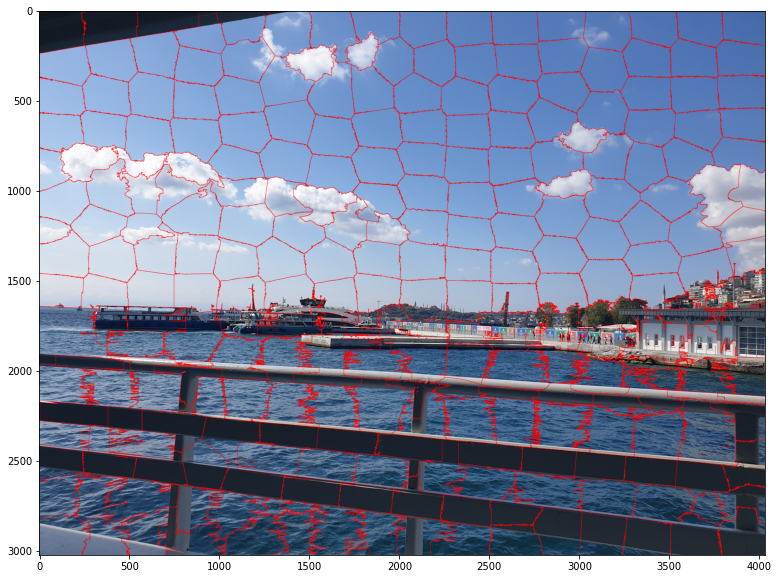

In [21]:
draw_boundries(main_img, get_boundries(main_img, labels_tmp))

As you can see, the result is pretty accurate, but, it's really slow

#### Enforce Connectivity #2

Here, I just used a basic median filter (from `scipy`) and applied it to the labels. It fixed the problmen (Not perfectly, but, OK) and also smoothed the boundries.

In [22]:
def remove_disjoint_components_and_smooth(labels, cnt, size):
    lab = labels.copy()
    for _ in range(cnt):
        lab = median_filter(lab, size)

    return lab

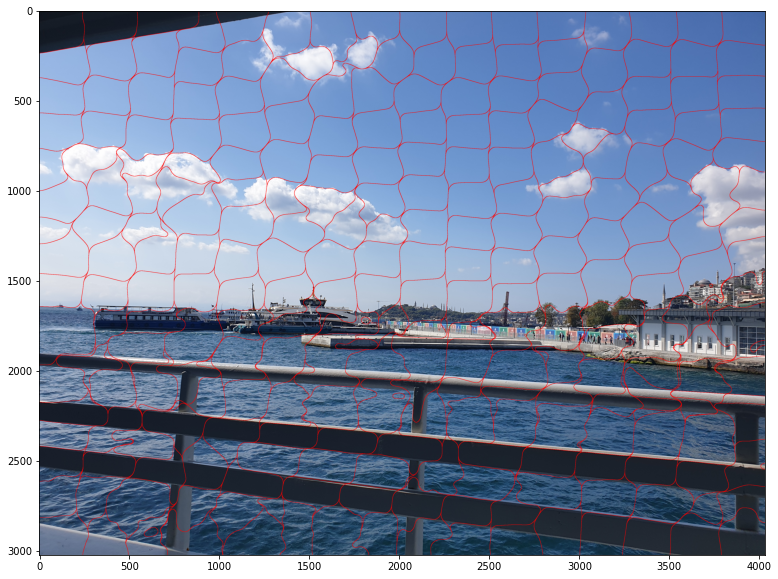

In [24]:
labels_final = remove_disjoint_components_and_smooth(labels, 5, int(S/6))

draw_boundries(main_img, get_boundries(main_img, labels_final))

## Other results

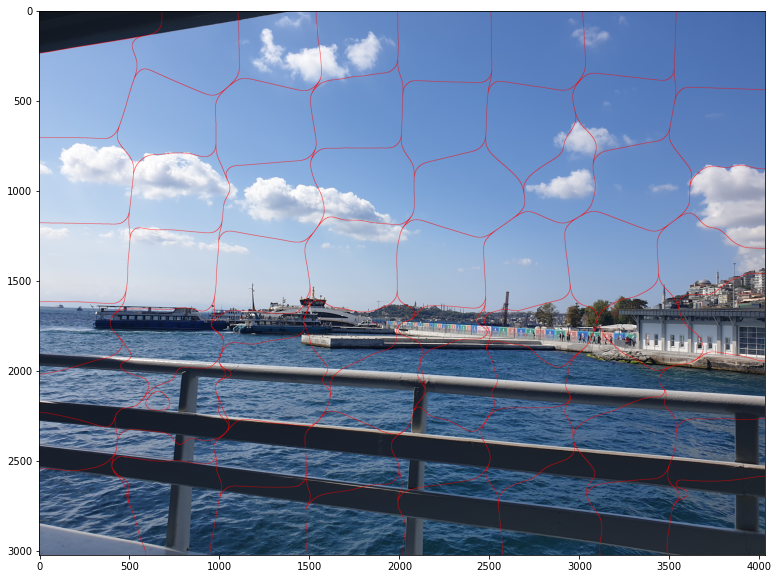

In [26]:
centers = unif_dist_centers(main_img, 8, 8)
S = centers[:2][:, 0].max() - centers[:2][:, 0].min()
centers = mode_image_away_from_edges(centers, sobel_img)
labels = segment(main_img, centers, features)
labels_final = remove_disjoint_components_and_smooth(labels, 6, int(S/8))
draw_boundries(main_img, get_boundries(main_img, labels_final))

100%|██████████| 10/10 [04:35<00:00, 27.60s/it]


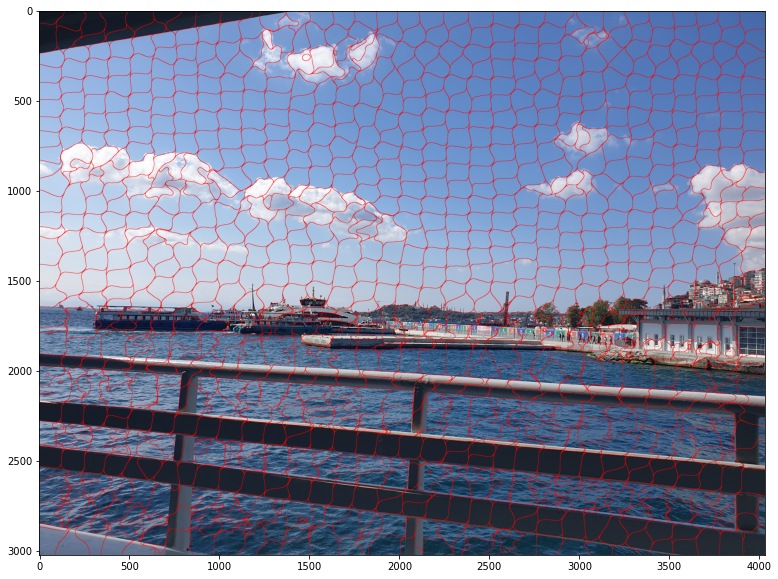

In [27]:
centers = unif_dist_centers(main_img, 32, 32)
S = centers[:2][:, 0].max() - centers[:2][:, 0].min()
centers = mode_image_away_from_edges(centers, sobel_img)
labels = segment(main_img, centers, features)
labels_final = remove_disjoint_components_and_smooth(labels, 6, int(S/5))
draw_boundries(main_img, get_boundries(main_img, labels_final))

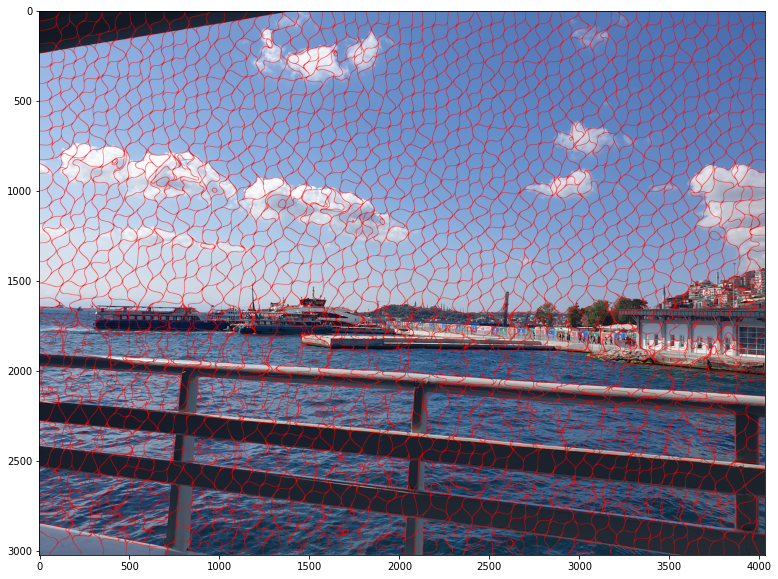

In [38]:
centers = unif_dist_centers(main_img, 32, 64)
S = centers[:2][:, 0].max() - centers[:2][:, 0].min()
centers = mode_image_away_from_edges(centers, sobel_img)
labels = segment(main_img, centers, features)
labels_final = remove_disjoint_components_and_smooth(labels, 7, int(S/5))
draw_boundries(main_img, get_boundries(main_img, labels_final))

**NOTICE**

Because of the fact that we want to enforce connectivity, we apply the aformentioned function for smoothness number of times. This will cause our code to take so long to finish. 

The boundries as you can see are so much smoothed. There is this trade off between boundry smoothness, and remove small components. If you don't apply these filters that much, you get good shapes boundries (but so many small components) but also the execution time will drop noticably.